In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip3 install matplotlib

# - Imports

In [2]:
import random, torch, pickle
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
from typing import Iterable, Tuple

# - SEED

In [3]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
with open("addition_dataset.pkl", "rb") as f:
    df = pickle.load(f)

print(df)

[('8 + 7', '15'), ('10 + 4', '14'), ('0 + 5', '5'), ('10 + 1', '11'), ('8 + 10', '18'), ('9 + 2', '11'), ('7 + 9', '16'), ('6 + 0', '6'), ('10 + 0', '10'), ('2 + 1', '3'), ('0 + 4', '4'), ('10 + 0', '10'), ('9 + 1', '10'), ('7 + 2', '9'), ('7 + 2', '9'), ('8 + 9', '17'), ('1 + 4', '5'), ('8 + 7', '15'), ('10 + 9', '19'), ('7 + 4', '11'), ('0 + 1', '1'), ('9 + 2', '11'), ('9 + 1', '10'), ('2 + 7', '9'), ('4 + 4', '8'), ('6 + 9', '15'), ('6 + 2', '8'), ('1 + 10', '11'), ('4 + 0', '4'), ('2 + 6', '8'), ('10 + 4', '14'), ('7 + 2', '9'), ('5 + 10', '15'), ('10 + 5', '15'), ('8 + 8', '16'), ('10 + 3', '13'), ('7 + 5', '12'), ('0 + 10', '10'), ('3 + 9', '12'), ('6 + 7', '13'), ('7 + 4', '11'), ('9 + 3', '12'), ('10 + 8', '18'), ('7 + 8', '15'), ('2 + 10', '12'), ('6 + 0', '6'), ('1 + 3', '4'), ('9 + 3', '12'), ('4 + 8', '12'), ('0 + 4', '4'), ('5 + 3', '8'), ('9 + 2', '11'), ('8 + 10', '18'), ('1 + 6', '7'), ('10 + 7', '17'), ('5 + 7', '12'), ('6 + 10', '16'), ('5 + 6', '11'), ('9 + 4', '13')

# - Tokenization

In [5]:
SPECIAL = ["<pad>", "<bos>", "<eos>"]
BASE_CHARS = sorted(set("0123456789+= "))
VOCAB = SPECIAL + BASE_CHARS
PAD, BOS, EOS = SPECIAL  # alias pratiques

char2idx = {ch: i for i, ch in enumerate(VOCAB)}
idx2char = {i: ch for ch, i in char2idx.items()}
VOCAB_SIZE = len(VOCAB)

INPUT_LEN = 9                               # « 99 + 99 » => 9 caractères max
OUTPUT_LEN = 2  # nb de chiffres de la somme
TGT_LEN = OUTPUT_LEN + 2                    # + BOS + EOS

print("VOCAB_SIZE =", VOCAB_SIZE)
print("OUTPUT_LEN =", OUTPUT_LEN)

VOCAB_SIZE = 16
OUTPUT_LEN = 2


# Cell 3 - Dataset

In [6]:
class AdditionDataset(Dataset):
    def __init__(self, data: Iterable[Tuple[str, str]]):
        self.x, self.y = [], []
        for inp_str, out_str in data:
            inp = inp_str[:INPUT_LEN].ljust(INPUT_LEN)
            out = out_str[:OUTPUT_LEN].ljust(OUTPUT_LEN)
            src_ids = [char2idx[c] for c in inp]
            tgt_ids = [char2idx[BOS]] + [char2idx[c] for c in out] + [char2idx[EOS]]
            tgt_ids += [char2idx[PAD]] * (TGT_LEN - len(tgt_ids))
            self.x.append(torch.tensor(src_ids, dtype=torch.long))
            self.y.append(torch.tensor(tgt_ids, dtype=torch.long))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [7]:
full_ds = AdditionDataset(df)
train_ds, test_ds = random_split(full_ds, [int(0.8*len(full_ds)), len(full_ds)-int(0.8*len(full_ds))])
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=32)

print("Dataset size:", len(full_ds))

Dataset size: 1000


In [8]:
xt, yt = test_ds[2]

xv = "".join([idx2char[i.item()] for i in xt])
yv = "".join([idx2char[i.item()] for i in yt])

print("xv =", xv)
print("yv =", yv)


xv = 5 + 8    
yv = <bos>13<eos>


# Cell 4 - Model

In [9]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int = 128,
                 n_heads: int = 4, n_layers: int = 2, pad_idx: int = 0):
        super().__init__()
        self.pad_idx = pad_idx
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.pos = nn.Embedding(512, emb_dim)
        self.dropout = nn.Dropout(0.1)

        enc_layer = nn.TransformerEncoderLayer(emb_dim, n_heads, dropout=0.1)
        dec_layer = nn.TransformerDecoderLayer(emb_dim, n_heads, dropout=0.1)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=n_layers)

        self.fc = nn.Linear(emb_dim, vocab_size)
        # weight tying = moins de params, meilleure généralisation
        self.fc.weight = self.emb.weight

    def add_pos(self, x):
        positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        return self.emb(x) + self.pos(positions)

    @staticmethod
    def causal_mask(sz, device):
        return torch.triu(torch.full((sz, sz), float('-inf'), device=device), 1)

    def forward(self, src, tgt):
        src_emb = self.dropout(self.add_pos(src))
        tgt_emb = self.dropout(self.add_pos(tgt))

        tgt_mask = self.causal_mask(tgt.size(1), tgt.device)
        src_key_padding = src.eq(self.pad_idx)
        tgt_key_padding = tgt.eq(self.pad_idx)

        memory = self.encoder(
            src_emb.transpose(0, 1),
            src_key_padding_mask=src_key_padding
        )
        out = self.decoder(
            tgt_emb.transpose(0, 1),
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding,
            memory_key_padding_mask=src_key_padding
        )
        return self.fc(out.transpose(0, 1))

In [10]:
def encode(s, pad_to=None):
    ids = [char2idx[c] for c in s]
    if pad_to:
        ids += [char2idx[PAD]] * (pad_to - len(ids))
    return ids
def smoke_test():
    model = Seq2SeqTransformer(VOCAB_SIZE, pad_idx=char2idx[PAD]).eval()

    # sample du dataset : "11 + 33  " (9 caractères pile)
    src_str = "11 + 33  "                 # INPUT_LEN = 9
    tgt_str = "<bos>"                     # on démarre la génération

    src = torch.tensor([encode(src_str)], dtype=torch.long)
    tgt = torch.tensor([[char2idx[BOS]]], dtype=torch.long)

    with torch.no_grad():
        out = model(src, tgt)             # -> shape [1, 1, VOCAB_SIZE]

    assert out.shape == (1, tgt.size(1), VOCAB_SIZE)
    print("✓ Forward pass OK – shapes conformes.")
    # Le modèle est random, c’est normal que la prédiction ne soit pas 44 !

smoke_test()

c:\Users\Admin\Desktop\GFlowNet_LLM_Bayes\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


✓ Forward pass OK – shapes conformes.


c:\Users\Admin\Desktop\GFlowNet_LLM_Bayes\.venv\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Seq2SeqTransformer(VOCAB_SIZE, pad_idx=char2idx[PAD]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=char2idx[PAD])
print("Device:", device)

c:\Users\Admin\Desktop\GFlowNet_LLM_Bayes\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Device: cuda


# Cell 5 : Setup

In [ ]:
EPOCHS = 40
train_losses = []
test_losses = []


In [26]:
scaler = torch.cuda.amp.GradScaler(enabled=device.startswith("cuda"))

for epoch in range(1, EPOCHS + 1):
    model.train(); total_loss = 0; n_tokens = 0

    for src, tgt in train_dl:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=device.startswith("cuda")):
            logits = model(src, tgt[:, :-1])
            loss   = loss_fn(
                logits.reshape(-1, VOCAB_SIZE),
                tgt[:, 1:].reshape(-1)
            )

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()

        total_loss += loss.item() * tgt[:, 1:].numel()
        n_tokens   += tgt[:, 1:].numel()

    train_losses.append(total_loss / n_tokens)

    # ----- eval -----
    model.eval(); total_loss = 0; n_tokens = 0
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=device.startswith("cuda")):
        for src, tgt in test_dl:
            src, tgt = src.to(device), tgt.to(device)
            logits = model(src, tgt[:, :-1])
            loss   = loss_fn(
                logits.reshape(-1, VOCAB_SIZE),
                tgt[:, 1:].reshape(-1)
            )
            total_loss += loss.item() * tgt[:, 1:].numel()
            n_tokens   += tgt[:, 1:].numel()
    test_losses.append(total_loss / n_tokens)

    print(f"Epoch {epoch:02d} – Train {train_losses[-1]:.4f} | Test {test_losses[-1]:.4f}")


C:\Users\Admin\AppData\Local\Temp\ipykernel_24868\2492785552.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.startswith("cuda"))
C:\Users\Admin\AppData\Local\Temp\ipykernel_24868\2492785552.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.startswith("cuda")):
C:\Users\Admin\AppData\Local\Temp\ipykernel_24868\2492785552.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=device.startswith("cuda")):


Epoch 01 – Train 0.3375 | Test 0.0623
Epoch 02 – Train 0.1281 | Test 0.0197
Epoch 03 – Train 0.0804 | Test 0.0081
Epoch 04 – Train 0.0549 | Test 0.0183
Epoch 05 – Train 0.0761 | Test 0.0165
Epoch 06 – Train 0.0461 | Test 0.0088
Epoch 07 – Train 0.0617 | Test 0.0238
Epoch 08 – Train 0.0630 | Test 0.0056
Epoch 09 – Train 0.0515 | Test 0.0052
Epoch 10 – Train 0.0572 | Test 0.0118
Epoch 11 – Train 0.0540 | Test 0.0151
Epoch 12 – Train 0.0365 | Test 0.0127
Epoch 13 – Train 0.0442 | Test 0.0061
Epoch 14 – Train 0.0414 | Test 0.0085
Epoch 15 – Train 0.0515 | Test 0.0002
Epoch 16 – Train 0.0292 | Test 0.0007
Epoch 17 – Train 0.0349 | Test 0.0022
Epoch 18 – Train 0.0424 | Test 0.0016
Epoch 19 – Train 0.0512 | Test 0.0012
Epoch 20 – Train 0.0254 | Test 0.0002


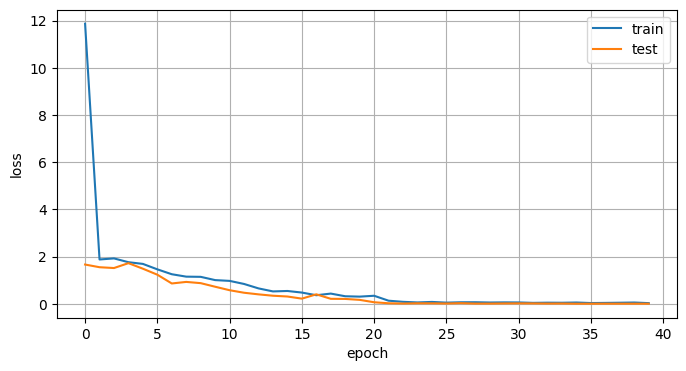

In [27]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='train'); plt.plot(test_losses, label='test')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.grid(True); plt.legend(); plt.show()

In [28]:
def decode(ids, skip_pad=True, strip=True):
    """
    - accepte list, numpy array ou tensor (CPU/GPU)
    - supprime les <pad> si skip_pad=True
    - enlève les espaces de fin si strip=True
    """
    if torch.is_tensor(ids):
        ids = ids.tolist()

    s = []
    for tok in ids:
        ch = idx2char.get(int(tok), '')      # int() si tok est un tensor
        if skip_pad and ch == PAD:
            continue
        s.append(ch)

    out = ''.join(s)
    return out.rstrip() if strip else out

@torch.inference_mode()
def generate(model, input_str, max_len=OUTPUT_LEN):
    model.eval()

    src_ids = [char2idx.get(c, char2idx[PAD])
               for c in input_str[:INPUT_LEN].ljust(INPUT_LEN)]
    src = torch.tensor([src_ids], device=device, dtype=torch.long)

    tgt = torch.tensor([[char2idx[BOS]]], device=device, dtype=torch.long)

    for _ in range(max_len):                         # plus de +1
        logits = model(src, tgt)
        next_token = logits[:, -1].argmax(-1, keepdim=True)
        tgt = torch.cat([tgt, next_token], dim=1)
        if next_token.item() == char2idx[EOS]:
            break

    pred_ids = tgt[0, 1:-1].tolist()                 # sans BOS/EOS
    return decode(pred_ids)


In [33]:
print(generate(model, "2 + 2"))   # ➜ "44" si modèle entraîné
print(generate(model, "1 + 10"))   # ➜ "19"

4
1


In [17]:
for i in range(5):
    x, y = train_ds[i]
    print("INPUT :", decode(x))
    print("TARGET:", decode(y))


INPUT : 7 + 0
TARGET: <bos>7 <eos>
INPUT : 0 + 3
TARGET: <bos>3 <eos>
INPUT : 6 + 5
TARGET: <bos>11<eos>
INPUT : 6 + 3
TARGET: <bos>9 <eos>
INPUT : 1 + 6
TARGET: <bos>7 <eos>


In [18]:
def random_tests(n=10):
    """Affiche n exemples pris au hasard dans le jeu de test."""
    n = min(n, len(test_ds))
    indices = random.sample(range(len(test_ds)), n)
    for sub_idx in indices:
        plain_inp, expected = test_ds.dataset.get_str(test_ds.indices[sub_idx])
        guess = generate(model, plain_inp)
        status = "✅" if guess.strip() == expected.strip() else "❌"
        print(f"{plain_inp} = {guess} (attendu {expected}) {status}")

In [19]:
random_tests(10)

AttributeError: 'AdditionDataset' object has no attribute 'get_str'